In [24]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
sys.path.append("/work/ariyanzarei/SorghumSegmentation/SorghumPartNet/models")
sys.path.append("/work/ariyanzarei/SorghumSegmentation/TreePartNet")

In [34]:
from SorghumPartNet.models.leaf_model import SorghumPartNetLeaf 
import h5py
import torch 
import numpy as np

checkpoint_path = "/space/murph186/sorghum_segmentation/models/model_checkpoints/leaf_net_2022_03_10_v1/lightning_logs/version_2/checkpoints/epoch=18-step=22800.ckpt"
test_dataset_path = "/space/murph186/sorghum_segmentation/dataset/2022-03-10_leaf_c/sorghum_leaf__labeled_test.hdf5"

test_dataset = h5py.File(test_dataset_path, 'r')
test_points = test_dataset["points"]
test_class = test_dataset["leaf_count"]

model = SorghumPartNetLeaf.load_from_checkpoint(checkpoint_path).cuda()

print(f"Test dataset size: {len(test_points)}")

miss_single = []
miss_double = []
for i in range(len(test_points)):

  p = torch.unsqueeze(torch.from_numpy(test_points[i]).to(torch.float32), dim=0).cuda()

  prediction = model(p)
  predicted_class = np.argmax(torch.nn.functional.softmax(prediction).detach().cpu().numpy())

  #print(test_class[i], predicted_class)

  if (test_class[i] == 2 and predicted_class == 1):
    miss_single.append(i)
  if (test_class[i] == 1 and predicted_class == 0):
    miss_double.append(i)

  if i % 100 == 0:
    print("torch.cuda.memory_allocated: %fGB"%(torch.cuda.memory_allocated(0)/1024/1024/1024))
    print(f"progress... {i}")


args(k=15, num_points=80)
Test dataset size: 1600
torch.cuda.memory_allocated: 0.128500GB
progress... 0


<ipython-input-34-61953e731363>:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  predicted_class = np.argmax(torch.nn.functional.softmax(prediction).detach().cpu().numpy())


torch.cuda.memory_allocated: 0.128500GB
progress... 100
torch.cuda.memory_allocated: 0.128500GB
progress... 200
torch.cuda.memory_allocated: 0.128500GB
progress... 300
torch.cuda.memory_allocated: 0.128500GB
progress... 400
torch.cuda.memory_allocated: 0.128500GB
progress... 500
torch.cuda.memory_allocated: 0.128500GB
progress... 600
torch.cuda.memory_allocated: 0.128500GB
progress... 700
torch.cuda.memory_allocated: 0.128500GB
progress... 800
torch.cuda.memory_allocated: 0.128500GB
progress... 900
torch.cuda.memory_allocated: 0.128500GB
progress... 1000
torch.cuda.memory_allocated: 0.128500GB
progress... 1100
torch.cuda.memory_allocated: 0.128500GB
progress... 1200
torch.cuda.memory_allocated: 0.128500GB
progress... 1300
torch.cuda.memory_allocated: 0.128500GB
progress... 1400
torch.cuda.memory_allocated: 0.128500GB
progress... 1500


In [27]:
print(model)

SorghumPartNetLeaf(
  (DGCNNBinaryClass): DGCNNBinaryClass(
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv1): Sequential(
      (0): Conv2d(6, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (conv2): Sequential(
      (0): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (conv3): Sequential(
      (0): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
  

In [28]:
from torchsummary import summary
summary(model, input_size=(80,3), batch_size=-1, device='cuda')

Layer (type:depth-idx)                   Param #
├─DGCNNBinaryClass: 1-1                  --
|    └─BatchNorm2d: 2-1                  128
|    └─BatchNorm2d: 2-2                  128
|    └─BatchNorm2d: 2-3                  256
|    └─BatchNorm2d: 2-4                  512
|    └─Sequential: 2-5                   --
|    |    └─Conv2d: 3-1                  384
|    |    └─BatchNorm2d: 3-2             (recursive)
|    |    └─LeakyReLU: 3-3               --
|    └─Sequential: 2-6                   --
|    |    └─Conv2d: 3-4                  8,192
|    |    └─BatchNorm2d: 3-5             (recursive)
|    |    └─LeakyReLU: 3-6               --
|    └─Sequential: 2-7                   --
|    |    └─Conv2d: 3-7                  16,384
|    |    └─BatchNorm2d: 3-8             (recursive)
|    |    └─LeakyReLU: 3-9               --
|    └─Sequential: 2-8                   --
|    |    └─Conv2d: 3-10                 65,536
|    |    └─BatchNorm2d: 3-11            (recursive)
|    |    └─LeakyRe

Layer (type:depth-idx)                   Param #
├─DGCNNBinaryClass: 1-1                  --
|    └─BatchNorm2d: 2-1                  128
|    └─BatchNorm2d: 2-2                  128
|    └─BatchNorm2d: 2-3                  256
|    └─BatchNorm2d: 2-4                  512
|    └─Sequential: 2-5                   --
|    |    └─Conv2d: 3-1                  384
|    |    └─BatchNorm2d: 3-2             (recursive)
|    |    └─LeakyReLU: 3-3               --
|    └─Sequential: 2-6                   --
|    |    └─Conv2d: 3-4                  8,192
|    |    └─BatchNorm2d: 3-5             (recursive)
|    |    └─LeakyReLU: 3-6               --
|    └─Sequential: 2-7                   --
|    |    └─Conv2d: 3-7                  16,384
|    |    └─BatchNorm2d: 3-8             (recursive)
|    |    └─LeakyReLU: 3-9               --
|    └─Sequential: 2-8                   --
|    |    └─Conv2d: 3-10                 65,536
|    |    └─BatchNorm2d: 3-11            (recursive)
|    |    └─LeakyRe

In [29]:
import matplotlib.pyplot as plt
import math

def plot_selected_samples(selected_points, selected_idx, title):
  # Plot single leaf point clouds
  columns = 3
  sample_count = len(selected_points)
  fig = plt.figure(figsize=(12, 0.6 * math.ceil(6 * sample_count/columns)))
  fig.suptitle(title)
  for i in range(sample_count):
    ax = fig.add_subplot(int(math.ceil(sample_count/columns)), columns, i+1, projection='3d')

    unique_leaf_indices = np.unique(selected_idx[i])
    leaf_one_idx = np.where(selected_idx[i] == unique_leaf_indices[0])

    leaf_one_points = selected_points[i,leaf_one_idx,:]

    # plot points from leaf one
    ax.scatter(
      leaf_one_points[0,:,0], 
      leaf_one_points[0,:,1], 
      leaf_one_points[0,:,2], c="b")

    # if leaf #2 plot points from leaf #2
    if len(unique_leaf_indices) == 2:
      leaf_two_idx = np.where(selected_idx[i] == unique_leaf_indices[1])
      leaf_two_points = selected_points[i, leaf_two_idx, :]

      ax.scatter(
        leaf_two_points[0,:,0], 
        leaf_two_points[0,:,1], 
        leaf_two_points[0,:,2], c="g")

    ax.set_box_aspect((np.ptp(leaf_one_points[0,:,0]),np.ptp(leaf_one_points[0,:,1]),np.ptp(leaf_one_points[0,:,2])))
    
    if len(unique_leaf_indices) > 2:
      print("[WARN] Found sample with more than two leaves.")

  plt.show()

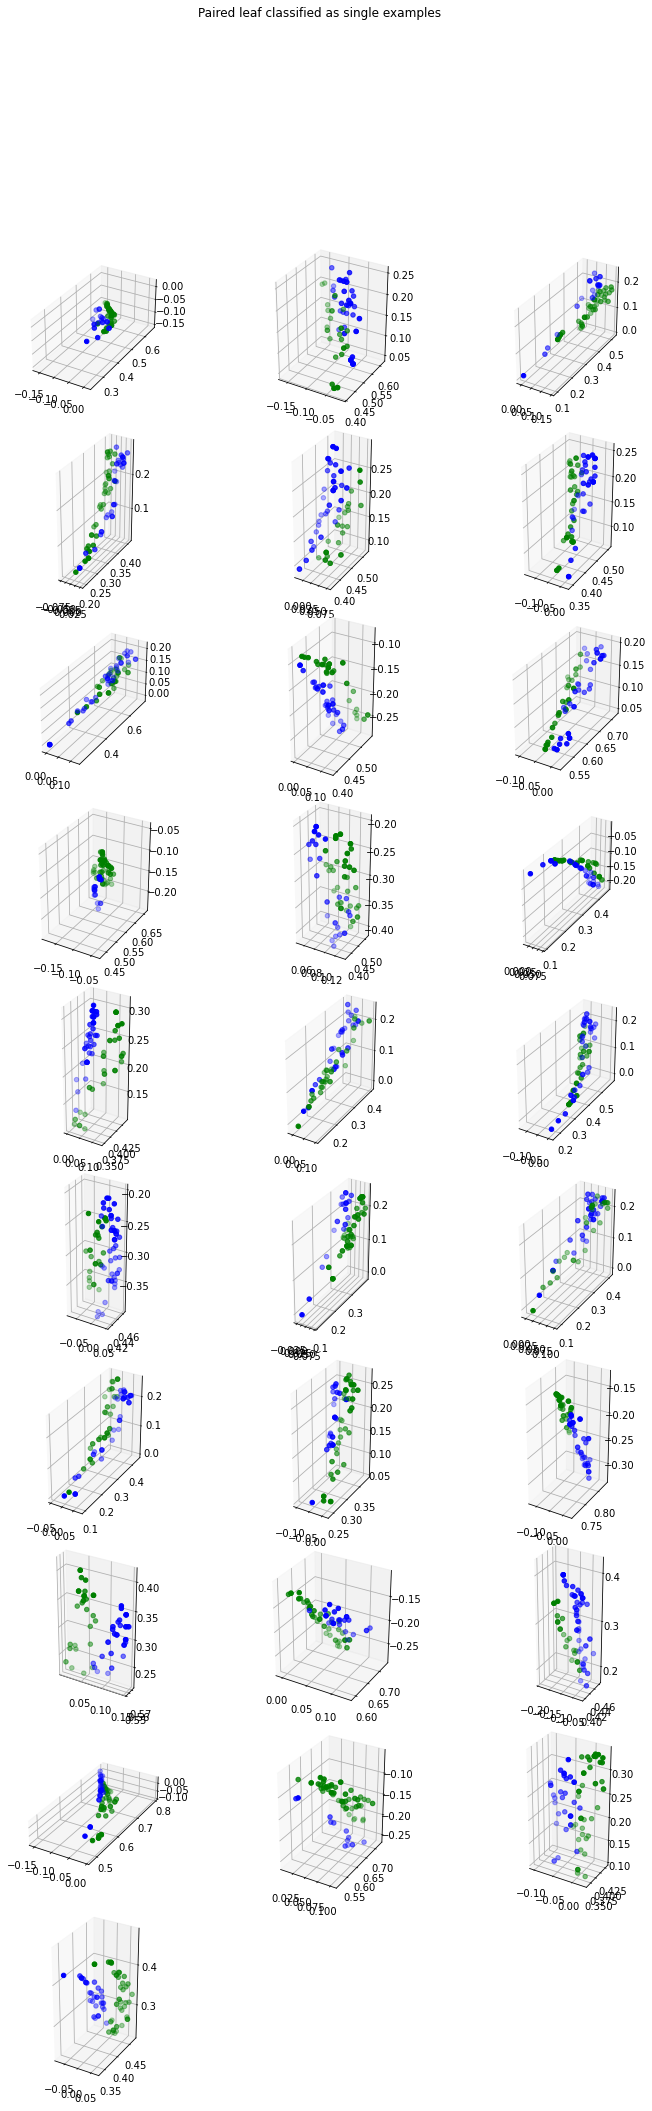

In [30]:
test_indices = test_dataset["leaf_index"]

miss_points = test_points[miss_single]
miss_idx = test_indices[miss_single]

plot_selected_samples(miss_points, miss_idx, "Paired leaf classified as single examples")



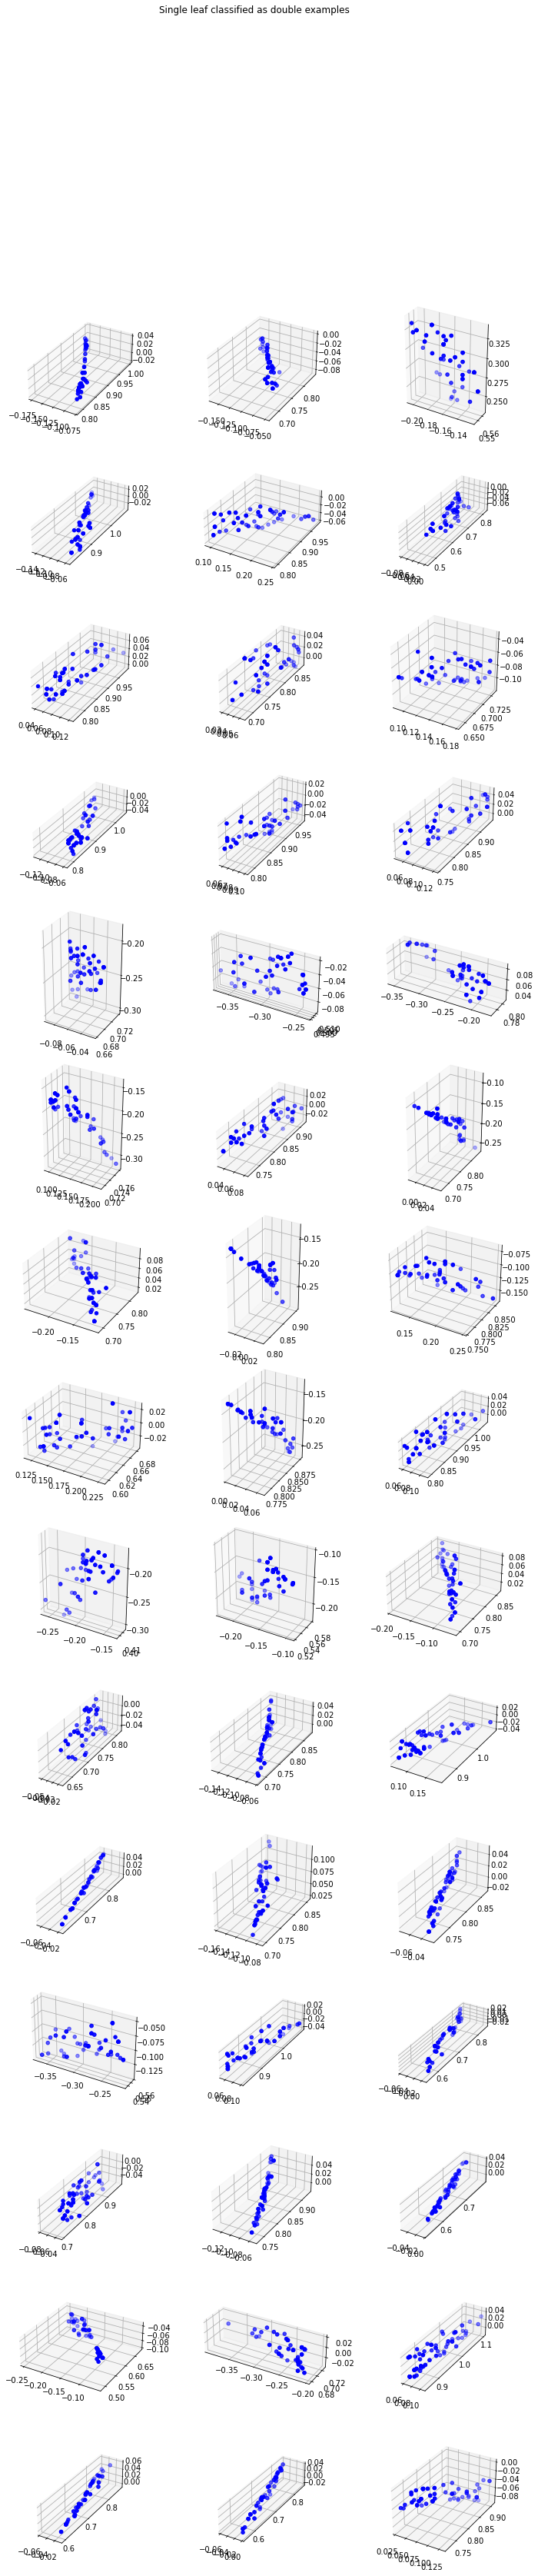

In [31]:
miss_points = test_points[miss_double]
miss_idx = test_indices[miss_double]

plot_selected_samples(miss_points, miss_idx, "Single leaf classified as double examples")

In [33]:
print( 1 - (len(miss_single) + len(miss_double)) / (len(test_points)))

print( (len(miss_single) ) / (len(test_points)))

print( (len(miss_double) ) / (len(test_points)))

0.954375
0.0175
0.028125
